# CONVOLUTIONAL NEURAL NETWORKS

Regular Neural Networks recieve an input (a single vector) and transform it through a series of hidden layers applying some non-linearity. Each hidden layer is made up of a set of neurons, where each neuron is fully connected to all neurons in the previous layer. The last fully-connected layer is called the <i>output</i> layer and it represents the class scores. Layer in regular nets are typically arranged as one-dimensional vectors.

In a convolutional neural net the inputs are 3D volumes (tensors) and each layer has its neurons arranged in 3 dimensions: <b>widht, height depth</b>.

![Conv Net](img/conv_net.png "Conv Net")

Convolutional neural networks typically use three main types of layer: <b>Convolutional Layer, Pooling Layer</b>, and <b> Fully-Connected Layer</b>. Every layer transforms one volume of activations to another through a series of manipulations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../")

from src.conv_net import ConvNetwork
from src.solver import SupervisedSolver
from src.layers import affine_forward, affine_backward, cross_entropy_loss
from src.layers import conv_2d_forward_naive, max_pool_2d_forward, max_pool_2d_backward
from src.utils.gradient_check import eval_numerical_gradient, rel_error
from src.utils.load_CIFAR10 import get_CIFAR10_data

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# plot configuration
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Convolutional Layer

The convolutional layer is the core building block of Convolutional neural networks. Every convolutional layer consists of a set of filters. During the forward pass we slide each filter across the width and the height of the input volume and compute dot products between the entries of the filter and the input at the current position (we perform convolution). Every filter is 3-dimensional and its third dimension extends through the full depth of the input volume. As we slide the filter over the width and height of the input volume we will produce a 2D activation map that gives the resposne of that filter at every spatial position. Each filter produces a separate 2D activation map, and stacking these maps along the depth dimension we produce the output volume.

![Conv Layer](img/conv_layer.png "Conv Layer")

In this setting each neuron is connected to only a local region of the input volume. The filter size along the width and the height is a hyperparameter and can be tuned. The extent of the connectivity along the depth, however, is always equal to the depth of the input volume. Additionally, all the neurons in a 2D slice are constrained to use the same weight parameters. That is, all the values for a given activation map are produced by sliding one filter across the width and height of the input volume. This parameter sharing scheme is based on the assumption that if one feature is useful to compute at some spatial position $ (x_{1}, y_{1}) $, then it should also be useful to compute at a different position $ (x_{2}, y_{2}) $.

![Conv Filter](img/conv_filter.png "Conv Filter")

During training the network will learn filters that activate when they "see" some type of feature. The number of the filters (and respectively the activation maps) is also a hyperparameter. Each filter will learn to "look" for something different in the input.  
Another hyperparameter is the <b>stride</b> with which we slide the filter. A stride of 1 means we move the filters one pixel at a time, a stride of 2 means the filters would jump 2 pixels at a time and so on. Obviously, the size of the output volume depends on the stride, and bigger strides would produce a smaller output volume.  
Sometimes it is convenient to pad the input volume with zeros around the border. This is called <b>zero-padding</b> and it allows us to control the spatial size of the output volumes.

In [2]:
# Check forward pass.
X = np.array([[[0,0,0,0,0],[1,1,0,2,1],[0,2,2,2,0],[2,2,2,0,1],[1,1,1,0,1]],
              [[0,2,2,1,0],[1,1,2,0,0],[0,1,0,1,2],[2,0,1,0,0],[1,1,1,0,0]],
              [[1,2,2,1,1],[2,0,0,0,1],[1,2,0,2,1],[0,2,2,0,2],[2,0,0,0,2]]])

filter_1 = np.array([[[ 1,-1, 0],[ 1, 0, 0],[ 0,-1, 0]],
                     [[ 1, 0, 1],[ 0, 0,-1],[ 0, 1, 1]],
                     [[ 1, 1, 1],[ 1, 0, 0],[ 1, 1, 1]]])
bias_1 = 1

filter_2 = np.array([[[ 1, 0, 0],[-1, 0, 0],[ 0, 0,-1]],
                     [[ 1,-1, 1],[-1, 0,-1],[ 0, 0, 1]],
                     [[-1, 1, 0],[-1,-1,-1],[-1,-1, 0]]])
bias_2 = 0

data = np.array([X])
filters = np.array([filter_1, filter_2])
biases = np.array([bias_1, bias_2])
conv_param = {"stride" : 2, "pad" : 1}
out, _ = conv_2d_forward_naive(data, filters, biases, conv_param)
print(out)

[[[[  2.   4.   2.]
   [  4.   9.   8.]
   [  0.   6.   2.]]

  [[ -7. -10.  -4.]
   [ -4. -12.  -5.]
   [ -5.  -1.   0.]]]]


![Conv Example](img/conv_example.png "Conv Example")

To gain a better understanding of the type of operation that convolutional layers pefrorm, let's manualy set up filters that perform common image processing operations (grayscale conversion and edge-detection). Let's apply these operations to two input images and visualize the results.

In [3]:
# !pip install imageio

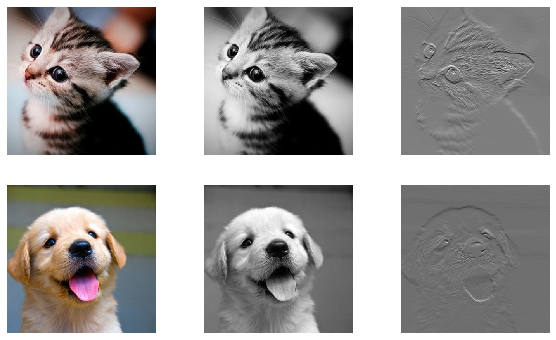

In [4]:
from imageio import imread
from PIL import Image

# Perform grey-scale conversion and edge-detection.
kitten = imread("img/_kitten.png")
puppy = imread("img/_puppy.png")

kitten = np.array(Image.fromarray(kitten)) # shape (384 x 384 x 3)
puppy = np.array(Image.fromarray(puppy)) # shape (384 x 384 x 3)

x = np.array([kitten.transpose((2, 0, 1)), puppy.transpose((2, 0, 1))])

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# The convolutions will be performed with stride of 1 and zero-padding of 1
conv_param = {"stride": 1, "pad": 1}

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_2d_forward_naive(x, w, b, conv_param)


# Convert the outputs to image pixel values
for _pic in range(out.shape[0]):
    for _filter in range(out.shape[1]):
        img = out[_pic, _filter]
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
        out[_pic, _filter] = img

kitten_grey = out[0,0]
kitten_edge = out[0,1]
puppy_grey = out[1,0]
puppy_edge = out[1,1]

pics = [kitten, kitten_grey, kitten_edge,
        puppy, puppy_grey, puppy_edge]


# Show the original images and the results of the conv operation
for ind in range(len(pics)):
    plt.subplot(2, 3, ind + 1)
    plt.imshow(pics[ind].astype("uint8"))
    plt.axis("off")

plt.gcf().set_size_inches(10, 6)
plt.show()

 It should be noted that the convolution operation essentially performs dot products between the filters and local regions of the input. A common implementation pattern is to take advantage of this fact and formulate the forward pass of a convolutional layer as one big matrix multiply. This is done as follows:
 * the local regions of the input volume are stretched out into columns and then all stretched out columns are assembled into one big input matrix
 * the weights of every filter are stretched out into rows and then all streteched out filters are assembled into one big filter matrix
 * the result of the convolution is equivalent to performing one large matrix multiply between the input matrix and the filter matrix
 * finally the result must be reshaped back to its proper output dimension

Since some values in the input volume are replicated multiple times, this approach could use a lot of memory. However, the benefit is that matrix multiplication is very efficient and speeds up performance substantially.

 // Backpropagation
 
 // Dilation


## Pooling Layer

The pooling layer operates independently on every depth slice of the input and resizes it spatialy, using the MAX operation. The depth dimension remains unchanged. The hyperparameters for the pooling layer are the spatial extent $ F $ and the stride $ S $.

There are only two commonly seen variations of the max pooling layer:
 * pooling with $ F = 3 $ and $ S = 2 $ (called overlapping pooling)
 * pooling with $ F = 2 $ and $ S = 2 $

Pooling sizes with larger receptive fields are too destructive.  
In addition to max pooling, the pooling units can also perform other functions, such as <i>average pooling</i> or <i>L2-norm pooling</i>. However, the max pooling has been imperically show to work best in practice.

Pooling layer are periodically inserted in-between succesive convolutional layers. The pooling layer is used to reduce the amount of parameters and computation in the network, and hence to control overfitting. 

![Pool Layer](img/conv_pool.png "Pool Layer")

In [5]:
# Check the forward pass.
X = np.array([[[[1,1,2,4],[5,6,7,8],[3,2,1,0],[1,2,3,4]]]])
X = X.astype(np.float64)
pool_param = {"pool_height":2, "pool_width":2, "stride":2}

y, cache = max_pool_2d_forward(X, pool_param)

print("X:\n", X)
print("max pool:\n", y)

X:
 [[[[1. 1. 2. 4.]
   [5. 6. 7. 8.]
   [3. 2. 1. 0.]
   [1. 2. 3. 4.]]]]
max pool:
 [[[[6. 8.]
   [3. 4.]]]]


In [6]:
# Check the backward pass.
np.random.seed(0)
num_classes = 10
labels = np.random.randint(low=1, high=num_classes)
W = np.random.randn(np.prod(y.shape), num_classes) * 1e-1
b = np.random.randn(num_classes) * 1e-1
W = W.astype(np.float64)
b = b.astype(np.float64)

scores, cache_out = affine_forward(y, W ,b)
_, dscores = cross_entropy_loss(scores, labels)
dy, _, _ = affine_backward(dscores, cache_out)
dx = max_pool_2d_backward(dy, cache)

f = lambda a: cross_entropy_loss(affine_forward(max_pool_2d_forward(a, pool_param)[0], W, b)[0], labels)[0]
dx_num = eval_numerical_gradient(f, X, verbose=False)

print("dx max relative error: %e" % (rel_error(dx_num, dx)))

dx max relative error: 1.180925e-10


## Fully-Connected Layer

Neurons in a fully-connected layer have full connections to all activations in the previous layer. The only difference between fully-connected and convolutional layers is that the neurons in the convolutional layer are connected only to a local region in the input, and that many of the neurons share parameters. However, the neurons in both layer still compute dot products, so their functional form is identical. If we set the filter size of a convolutional layer to be exactly equal to the spatial size of the input volume, then the convolutional layer transforms to a fully-connected layer.

![Conv FC Layer](img/conv_fc_layer.png "Conv FC Layer")

In [7]:
# Converting FC layer to CONV layer.
num_classes = 10
img = np.random.randint(low=0, high=255, size=(1, 3, 32, 32))
W = np.random.randn(np.prod(img.shape), num_classes) * 1e-2
b = np.random.randn(num_classes)

# FC layer using affine_forward.
fc_naive, _ = affine_forward(img, W, b)
print(fc_naive.flatten())

# FC layer using conv_2d_forward.
conv_param = {"stride":1, "pad":0}
W_conv = W.transpose(1, 0).reshape(num_classes, 3, 32, 32)
fc_conv, _ = conv_2d_forward_naive(img, W_conv, b, conv_param)
print(fc_conv.flatten())

[ -28.34284825    6.76463442 -145.6766767   -69.71933485   41.46692996
  -21.77844925 -124.30544256  -61.81417382   17.64287959  -34.2831232 ]
[ -28.34284825    6.76463442 -145.6766767   -69.71933485   41.46692996
  -21.77844925 -124.30544256  -61.81417382   17.64287959  -34.2831232 ]


## Training on CIFAR-10

We will train a convolutional neural network on the CIFAR-10 dataset that performs calssification over the number of classes.  
The objective during training will be to minimize the cross-entropy loss between the true distribution and the estimated distribution.  

The architecture of the convolutional network is:  
`CONV` - `ReLU` - `POOL` - `CONV` - `ReLU` - `POOL` - `FC` - `ReLU` - `FC` - `SOFTMAX`

The convolutional layers use filters of size `3x3` and stride of one, and the max-pool layers consist of filters with size `2x2` and stride of two. The first convolutional layer has `6` filter maps and the second convolutional layer has `32` filter maps. The dimension of the fully-connected hidden layer is `512`.  
Parameter update is performed using Adam update rule.

The CIFAR-10 dataset is examined in this notebook. The dataset can be downloaded from here:  
http://www.cs.toronto.edu/~kriz/cifar.html

The dataset consists of 60000 32x32 colour images in 10 classes. There are 50000 training images and 10000 test images. The test batch contains exactly 1000 randomly-selected images from each class.
Description of the dataset and functions for loading it are provided in the download-link above. 

In [8]:
# Load preprocessed CIFAR-10 data.
cifar10_dir = "../datasets/CIFAR-10/cifar-10-batches-py"
data = get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, num_test=1000,
                        zero_center=True, normalize=False, whiten=False)

for k, v in data.items():
    print("%s: " % k, v.shape)
    
image_size = data["X_train"].shape[1:]
num_classes = data["classes"].shape[0]
print("\nimage size:", image_size)
print("Number of classes:", num_classes)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)
classes:  (10,)

image size: (3, 32, 32)
Number of classes: 10


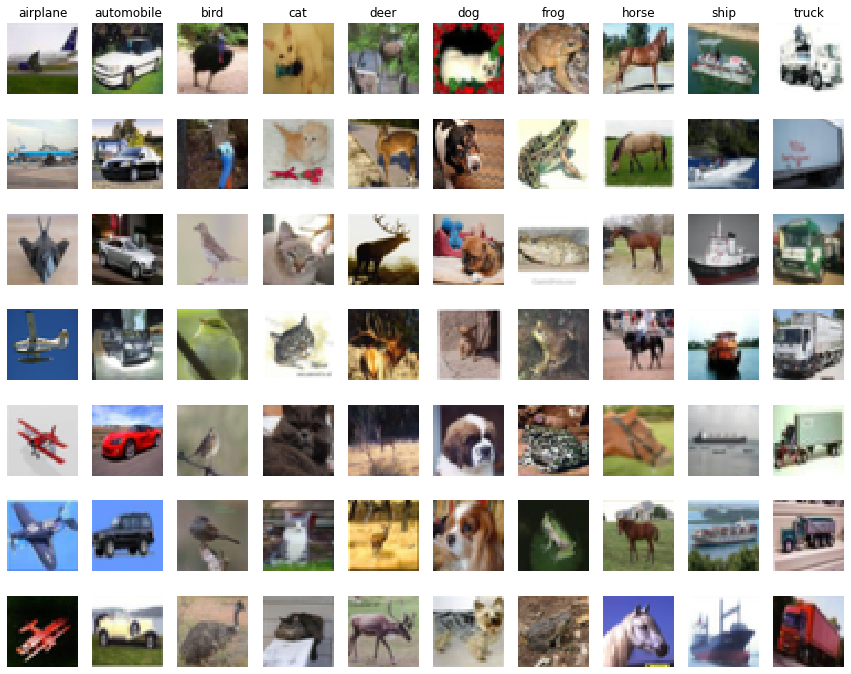

In [9]:
# Show a few examples of training images from each class.

# Reverse zero-centering and reshape for printing.
min_img = np.min(data["X_train"], axis=0)
img = data["X_train"] - min_img
img = img.transpose(0, 2, 3, 1)

# Visualize some examples from the dataset.
num_classes = len(data["classes"])
samples_per_class = 7

for y, cls in enumerate(data["classes"]):
    idxs = np.flatnonzero(data["y_train"] == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(img[idx].astype("uint8"))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

del img

In [10]:
class CIFAR10_dataset(object):
    def __init__(self, data):
        """
        Inputs:
        - data: A dictionary of training and validation data containing:
          "X_train": A numpy array of shape (N_train, d_1, ..., d_k) of training examples
          "X_val": A numpy array of shape (N_val, d_1, ..., d_k) of validation examples
          "y_train": A numpy array of shape (N_train, ) of labels for training examples
          "y_val": A numpy array of shape (N_val, ) of labels for validation examples
        """
        self.data = data

    def train_batch(self, batch_size=-1):
        """
        Inputs:
        - batch_size: Integer, giving the size of the batch to be generated.
        
        Returns:
        - X_batch: A numpy array of shape (batch_size, d1, ..., dk) of training examples.
        - y_batch: A numpy array of shape (batch_size, ) of labels for training examples.
        """
        num_train = self.data["X_train"].shape[0]
        batch_mask = np.random.choice(num_train, batch_size)
        X_batch = self.data["X_train"][batch_mask]
        y_batch = self.data["y_train"][batch_mask]

        return X_batch, y_batch

    def val_batch(self, batch_size=-1):
        """
        Inputs:
        - num_val: Integer, giving the size of the batch to be generated.
          If num_val = -1, the entire validation set is returned.
        
        Returns:
        - X_batch: A numpy array of shape (batch_size, d1, ..., dk) of validation examples.
        - y_batch: A numpy array of shape (batch_size, ) of labels for validation examples.
        """
        return self.data["X_val"][:batch_size], self.data["y_val"][:batch_size]

    def num_train(self):
        """
        Returns:
        - num_train: Integer, giving the number of training examples in the dataset.
        """
        return self.data["X_train"].shape[0]

    def num_val(self):
        """
        Returns:
        - num_val: Integer, giving the number of validation examples in the dataset.
        """
        return self.data["X_val"].shape[0]

In [11]:
# Initialize the dataset.
dataset = CIFAR10_dataset(data)

# Initialize the conv net.
cnn_model = ConvNetwork(channels_1=6, channels_2=32, hidden_dim=512, reg=0.0, weight_scale=1e-3)

In [12]:
# Train the network.
cnn_solver = SupervisedSolver(cnn_model, dataset,
                              update_rule="adam",
                              optim_config={"learning_rate":1e-3},
                              lr_decay=0.99,
                              batch_size=128,
                              num_epochs=3,
                              print_every=100,
                              verbose=True)

tic = time.time()
cnn_solver.train()
toc = time.time()
print("training took %.1f minutes" % ((toc - tic) / 60))

Number of iterations per epoch: 382
(Iteration 1 / 1146) loss: 2.30259
(Iteration 1 / 1146); (Epoch 1 / 3); train acc: 0.101000; val_acc: 0.112112
(Iteration 101 / 1146) loss: 1.77534
(Iteration 201 / 1146) loss: 1.51939
(Iteration 301 / 1146) loss: 1.43017
(Iteration 383 / 1146); (Epoch 2 / 3); train acc: 0.548000; val_acc: 0.550551
(Iteration 401 / 1146) loss: 1.17597
(Iteration 501 / 1146) loss: 1.07377
(Iteration 601 / 1146) loss: 1.25272
(Iteration 701 / 1146) loss: 0.99613
(Iteration 765 / 1146); (Epoch 3 / 3); train acc: 0.641000; val_acc: 0.601602
(Iteration 801 / 1146) loss: 1.11619
(Iteration 901 / 1146) loss: 0.90003
(Iteration 1001 / 1146) loss: 0.91852
(Iteration 1101 / 1146) loss: 0.94866
(Iteration 1146 / 1146); (Epoch 3 / 3); train acc: 0.701000; val_acc: 0.624625
training took 33.6 minutes


In [13]:
# Predict on the training and the validation set.
train_acc = cnn_solver.check_accuracy(data["X_train"], data["y_train"])
val_acc = cnn_solver.check_accuracy(data["X_val"], data["y_val"])
print("Train accuracy: %.5f" % train_acc)
print("Validation accuracy: %.5f" % val_acc)

# Predict on the test set.
test_acc = cnn_solver.check_accuracy(data["X_test"], data["y_test"])
print("Test accuracy using Adam: %.5f" % test_acc)

Train accuracy: 0.71457
Validation accuracy: 0.62500
Test accuracy using Adam: 0.65600


## Architectures

### LeNet-5
The architecture of LeNet-5 is described by Yann LeCun, Leon Bottou, Yoshua Bengio and Patrick Haffner in their paper from 1998:  
<i>[1] Gradient-Based Learning Applied to Document Recognition</i>

One of the first published convolutional neural networks for the purpose of recognizing handwritten digits in images is LeNet-5. It was first demonstrated by the authors of [1] that it was possible to train convolutional neural networks with backpropagation. Their model achieved outstanding results at that time and was adopted to recognize digits for processing deposits in ATM machines.

LeNet-5 comprises 7 layers, not counting the input. It was designed to recognize digits in `28x28` pixel images. The input to the network is a `32x32` pixel image, thus `28x28` images are padded on all sides with 2 rows of zeros. The reson is that it is desirable that potential distinctive features appearing in the corners would appear in the center of the receptive fields.  
Also, usually the characters in the database are `20 x 20` pixels centered in a `28 x 28` field. In LeNet-5, the set of centers of the receptive fields of the last convolutional layer form a `20 x 20` area in the center of the `32 x 32` input.


The first layer $ C_{1} $ is a convolutional layer comprising of 6 feature maps. The size of the filters (<i>the receptive field</i>) is `5x5`. Filters are slided with a stride of 1. The output of the first layer is a volume of size `6 x 28 x 28`.  
The second layer $ S_{2} $ is a sub-sampling average pooling layer with filter size `2x2` and stride of 2. Each unit computes the average of its four inputs, multiplies it by a trainable coefficient, adds a bias, and passes the result through an activation function (sigmoid, tanh). These trainable coefficient and bias control the effect of the activation non-linearity. If the coefficient is small, then the unit operates in a quasi-linear mode. If the coefficient is large, sub-sampling units can be seen as performin a "noisy OR" or a "noisy AND" function, depending on the value of the bias. The output of the second layer is a volume of size `6 x 14 x 14`

![LeNet-5](img/conv_lenet5.png "LeNet-5")

The third layer $ C_{3} $ is a convolutional layer with 16 feature maps. The size of the filter is 5x5, and the stride is 1. However, the filter does not exted through the entire depth of the input volume, but it "skips" some of the 2D slices. The set of features maps of $ S_{2} $ combined by each feature map in layer $ C_{3} $ are shown in the following table:

|    | 01 | 02 | 03 | 04 | 05 | 06 | 07 | 08 | 09 | 10 | 11 | 12 | 13 | 14 | 15 | 16 |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  1 |  X |    |    |    |  X |  X |  X |    |    |  X |  X |  X |  X |    |  X |  X |
|  2 |  X |  X |    |    |    |  X |  X |  X |    |    |  X |  X |  X |  X |    |  X |
|  3 |  X |  X |  X |    |    |    |  X |  X |  X |    |    |  X |    |  X |  X |  X |
|  4 |    |  X |  X |  X |    |    |  X |  X |  X |  X |    |    |  X |    |  X |  X |
|  5 |    |    |  X |  X |  X |    |    |  X |  X |  X |  X |    |  X |  X |    |  X |
|  6 |    |    |    |  X |  X | X  |    |    |  X |  X |  X |  X |    |  X |  X |  X |

Why not extend the feature maps through the entire depth of the input volume? The reason is twofold. First, a non-complete connection scheme forces a break of symmetry in the network. Different feature maps are forced to extract different features, because they get different sets of inputs. The first six feature maps of $ C_{3} $ take input from every contiguous subset of three feature maps of $ S_{2} $. The next six take input from every contiguous subset of four. The next three take input from some discontinuous subsets of four. And, finally, the last one takes input from all feature maps of $ S_{2} $. The output of the third layer is a volume with size `16 x 10 x 10`.  
The fourth layer $ S_{4} $ is again a sub-sampling layer, similar to $ S_{2} $. The output is a volume with size `16 x 5 x 5`.  
The fifth layer $ C_{5} $ is a convolutional layer with 120 feature maps. The size of the filter is 5x5, and the stride is 1. In this layer, the filters extend through the entire depth of the input volume. Since the size of the filter matches the spatial size of the input volume, layer $ C_{5} $ is actually a fully-connected layer. The output of layer $ C_{5} $ is a volume of size `120 x 1 x 1`. However, the layer is labeled as convolutional, because if LeNet-5 input were made bigger with everything else kept constant, the spatial dimension of the output would be larger than `1 x 1`.  
The sixth layer $ F_{6} $ is a fully-connected layer with 84 hidden units.

The activation function of all hidden layers is a scaled hyperpolic tangent:

$$ f(x) = A tanh(Sx) $$

where $ A $ is the amplitude of the function, and $ S $ determines its slope at the origin.  
The function $ f $ is odd, with horizontal asymptotes at $ +A $ and $ -A $. The chosen constants are $ A = 1.7159 $ and $ S = 0.6667 $. With this choice of parameters, the equalities $ f(1) = 1 $ and $ f(-1) = -1 $ are satisfied.

The output layer $ O_{7} $ is composed of Euclidean Radial Basis Function units (RBF), one for each class. The output of each RBF unit $ y_{i} $ is computed as follows:

$$ \displaystyle y_{i} = \sum_{j} (x_{j} - w_{ij})^{2} $$

In other words, each output RBF unit computes the Euclidian distance between its input vector and its parameter vector. The further away is the input from the parameter vector, the larger is the RBF output. The parameter vectors of these units are chosen by hand and kept fixed. The components of those parameter vectors are set to `-1` or `+1` and are designed to represent a stylized image of the corresponding character class drawn on a `7 x 12` bitmap. This technique explains the reason why layer $ F_{6} $ has exactly `84` hidden units.

Finally, the loss function used is a form of the cross-entropy loss.